# Cross-Domain Neural Networks for JPEG Decompression

This Jupyter Notebook trains cross-domain neural network models for JPEG decompression.

<a href=#data>Load Data</a>

<a href=#networka>Network A</a>: DCT-Image Domain (DI) W-net

<a href=#networkb>Network B</a>: Image-DCT Domain (ID) W-net

<a href=#networkc>Network C</a>: DCT-Image Domain (DI) AUTOMAP-inspired Network

<a href=#networkd>Network D</a>: Image-DCT Domain (ID) AUTOMAP-inspired Network

<a href=#networke>Network E</a>: DCT-Image Domain (DI) W-net (No Data Consistency)

<a href=#networkf>Network F</a>: Image-DCT Domain (ID) W-net (No Data Consistency)

## Data Consistency

Data consistency measures are taken by ensuring that the DCT coefficients predicted by either U-nets are not outside the allowed quantization values:

$$X_{reconstruction} \in [X_{JPEG} - \frac{Q}{2} , X_{JPEG} + \frac{Q}{2}]$$

where <br>
$X_{reconstruction}$ is the deep learning reconstructed image,<br>
$X_{JPEG}$ is the JPEG-decompressed image,<br>
$Q$ is the JPEG quality factor

In [1]:
from __future__ import print_function, division
import matplotlib.pylab as plt
import numpy as np
from keras.optimizers import Adam
import os
import glob
import io
from PIL import Image
import sys
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

# Importing our U-Net model
MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
from cdd_models import dc_loss, cust_loss, \
residual_wnet_di_dc, residual_wnet_id_dc,fcu_di_dc,fcu_id_dc,deep_cascade_unet
from dctools import py_dct2d, py_idct2d, dct_in_blocks, idct_in_blocks, get_quantization_matrix, \
extract_image_patches, compile_image_patches

Using TensorFlow backend.
/DATA/Projects/CTRECON/python/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/DATA/Projects/CTRECON/python/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/DATA/Projects/CTRECON/python/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/DATA/Projects/CTREC

# =============================================================
<a name='data'/>

In [2]:
# Some network parameters

H,W = 256, 256
norm = 128.0
compr_range = (10,20)

useDC = True
useImageNet = True

epochs = 100
batch_size= 16
patience = 10 # early stopping
if useImageNet:
    lr = 0.001
else:
    lr = 0.0001


# Load Data

In [3]:
# Train and validation data paths

if useImageNet:
    images_path = "ImageNet/*.tif"
    images = glob.glob(images_path)
    print(len(images))
    # Listing train and validation images
    train_images = images[0:75]
    val_images = images[75:]

    # Summary of images
    print("Train set size:", len(train_images))
    print("Validation set size:",len(val_images))
    #print("Test set size:",len(test_images))
    
else:
    # Train and validation data paths
    train_path = "/Volumes/Projects/JPEGDL/Dataset/MRDataset/Development/Training/*.tif"
    val_path = "/Volumes/Projects/JPEGDL/Dataset/MRDataset/Development/Validation/*.tif"
    test_path = "/Volumes/Projects/JPEGDL/Dataset/MRDataset/Testing/*.tif"

    # Listing train and validation images
    train_images = glob.glob(train_path)
    val_images = glob.glob(val_path)
    test_images = glob.glob(test_path)

    # Summary of images
    print("Train set size:", len(train_images))
    print("Validation set size:",len(val_images))
    print("Testing set size:",len(test_images))

98
Train set size: 75
Validation set size: 23


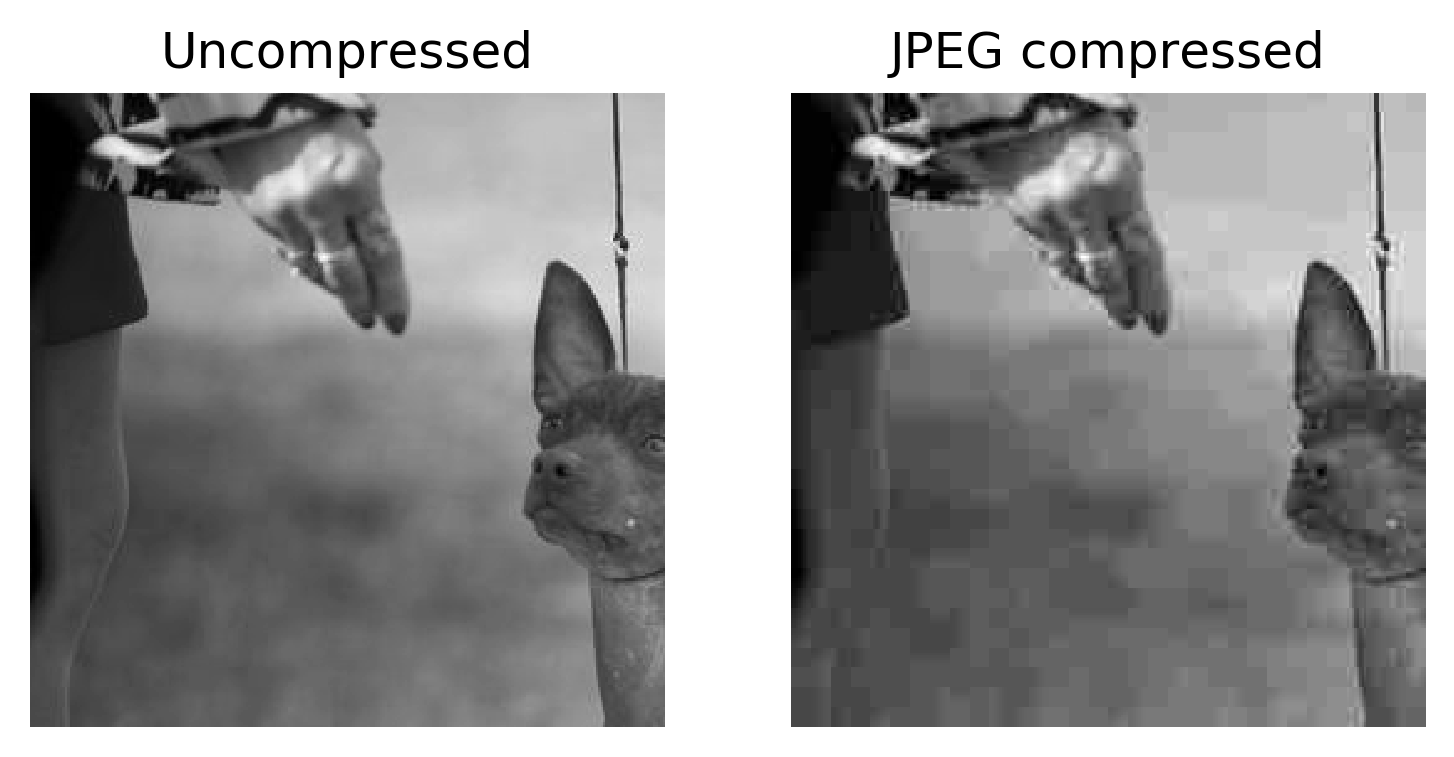

In [4]:
# Load uncompressed image
im1 = Image.open(train_images[50])
im1_array = np.array(im1)

# JPEG compress the image    
buffer = io.BytesIO()
im1.save(buffer, "JPEG", quality=15)
im2 = Image.open(buffer)
im2_array = np.array(im2)

# Display the images
plt.figure(dpi=300)
plt.subplot(1,2,1)
plt.imshow(im1_array,cmap = "gray")
plt.axis("off")
plt.title("Uncompressed")
plt.subplot(1,2,2)
plt.imshow(im2_array,cmap = "gray")
plt.axis("off")
plt.title("JPEG compressed")
plt.show()

In [5]:
train_unc = np.zeros((len(train_images),H,W,1),dtype = np.float32)
val_unc = np.zeros((len(val_images),H,W,1),dtype = np.float32)
val_qmat = np.zeros((len(val_images),H,W,1),dtype = np.float32)
np.random.seed(965)
compr_val = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(val_images),replace = True)

train_compr = np.zeros_like(train_unc)
val_compr = np.zeros_like(val_unc)

# Train set
for ii in range(len(train_images)):
    # Load uncompressed image
    im1 = Image.open(train_images[ii])
    train_unc[ii,:,:,0] = np.array(im1, dtype=np.float32)
        
# Validation set
for ii in range(len(val_images)):
    # Load uncompressed image
    im1 = Image.open(val_images[ii])
    val_unc[ii,:,:,0] = np.array(im1, dtype=np.float32)

    # JPEG compress the image    
    buf = io.BytesIO()
    im1.save(buf, "JPEG", quality=int(compr_val[ii]))
    im2 = Image.open(buf)
    val_compr[ii,:,:,0] = np.array(im2, dtype=np.float32)
    
    # Get the quantization matrix and arrange the matrix into 8x8 patches (JPEG standard)
    val_qmat[ii,:,:,0] = get_quantization_matrix(im2, block_size = (8,8), im_size = (256, 256))

# Normalize all images by centering image values around 0 (subtract by 128.0) and dividing by 128.0
# Centering the image values around 0 is the JPEG compression standard
val_unc -= norm
val_unc /= norm

val_compr -= norm
val_compr /= norm

val_qmat /= norm

(23, 256, 256, 1)
-1.0 0.9921875 -0.2526902
-1.0 0.9921875 -0.25293112


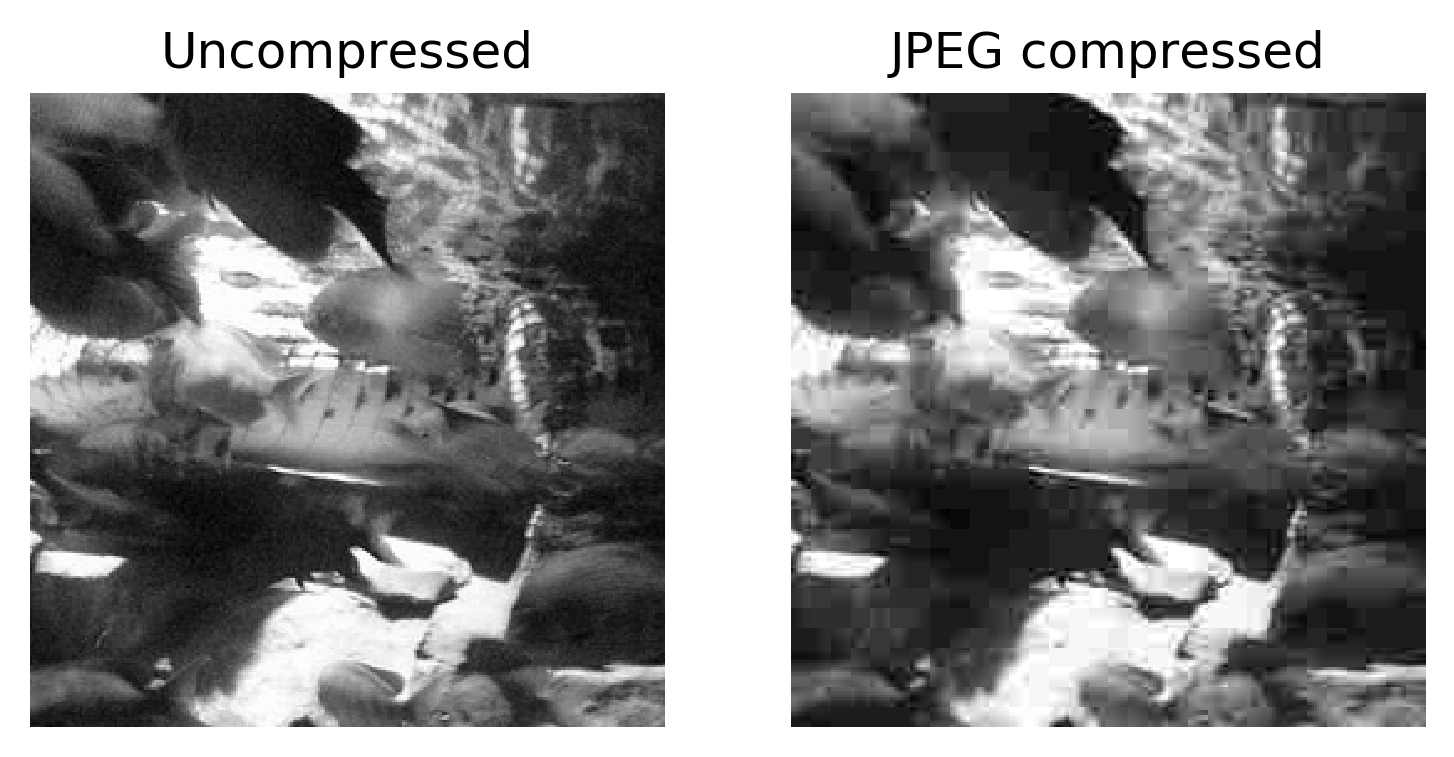

In [6]:
nn = 5

print(val_unc.shape)
print(val_unc[nn,:,:,0].min(),val_unc[nn,:,:,0].max(), val_unc[nn,:,:,0].mean())
print(val_compr[nn,:,:,0].min(),val_compr[nn,:,:,0].max(), val_compr[nn,:,:,0].mean())

# JPEG compress the image    
buffer = io.BytesIO()
im1.save(buffer, "JPEG", quality=15)
im2 = Image.open(buffer)
im2_array = np.array(im2)

# Display the images
plt.figure(dpi=300)
plt.subplot(1,2,1)
plt.imshow(val_unc[nn,:,:,0],cmap = "gray")
plt.axis("off")
plt.title("Uncompressed")
plt.subplot(1,2,2)
plt.imshow(val_compr[nn,:,:,0],cmap = "gray")
plt.axis("off")
plt.title("JPEG compressed")
plt.show()

In [8]:
# Data augmentation of training data        
        
def combine_generator_dc(gen1,compr_range):
    while True:
        batch_unc = gen1.next()
        batch_comp = np.zeros_like(batch_unc)
        train_qmat = np.zeros_like(batch_unc)
        
        np.random.seed(905)
        compr = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                           batch_unc.shape[0],replace = True)

        for ii in range(batch_unc.shape[0]):
            # JPEG compress the image    
            im1 = Image.fromarray(np.uint8(batch_unc[ii,:,:,0]))
            buffer = io.BytesIO()
            im1.save(buffer, "JPEG", quality=int(compr[ii]))
            im2 = Image.open(buffer)
            batch_comp[ii,:,:,0] = np.array(im2,dtype=np.float32)
            train_qmat[ii,:,:,0] = get_quantization_matrix(im2, block_size = (8,8), im_size = (256, 256))
            
            out_unc = (batch_unc - norm) / norm
            out_comp = (batch_comp - norm) / norm
            
        yield([out_comp, train_qmat/norm], [out_unc,out_unc,out_unc,out_unc])
        

        
seed = 905
image_datagen1 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.075,
        height_shift_range=0.075,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

image_datagen1.fit(train_unc, augment=True, seed=seed)

image_generator1 = image_datagen1.flow(train_unc,batch_size = batch_size,seed = seed)

combined = combine_generator_dc(image_generator1,compr_range)

(16, 256, 256, 1)
-1.0 0.9921875 -0.11160242
-1.0 0.9921875 -0.10791259


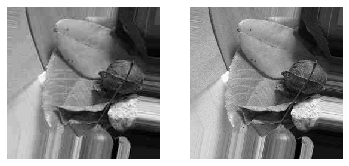

In [9]:
# sample data augmentation
if useDC:
    for ii in combined:
        print(ii[0][0].shape)
        print(ii[0][0].min(),ii[0][0].max(), ii[0][0].mean())
        print(ii[1][0].min(),ii[1][0].max(), ii[1][0].mean())
        plt.figure()
        plt.subplot(121)
        plt.imshow(ii[0][0][2,:,:,0],cmap = 'gray')
        plt.axis("off")
        plt.subplot(122)
        plt.imshow(ii[1][0][2,:,:,0],cmap = 'gray')
        plt.axis("off")
        plt.show()
        break
else:
    for ii in combined:
        print(ii[0][0].shape, ii[1][0].shape)
        print(ii[0][0].min(),ii[0][0].max())
        print(ii[1][0].min(),ii[1][0].max())
        print(ii[1][0][2,:,:,0].min(),ii[1][0][2,:,:,0].max())
        plt.figure()
        plt.subplot(121)
        plt.imshow(ii[0][0][2,:,:,0],cmap = 'gray')
        plt.axis("off")
        plt.subplot(122)
        plt.imshow(ii[1][0][2,:,:,0],cmap = 'gray')
        plt.axis("off")
        plt.show()
        break

# =============================================================
<a name='networka'/>

# Network A: DCT-Image Domain (DI) W-net

Two U-nets, first operating in the DCT domain and second in the image domain, are concatenated such that the result of the DCT-domain U-net is the input to the image-domain U-net in an end-to-end fashion.

In [12]:
# Set domain configuration here
depth_str = 'di' 

date = '20190823'
qfrange = str(compr_range[0]) + '_' + str(compr_range[1])

useDC=True

if useDC:
    dcstr = 'dc'
else:
    dcstr = 'nodc'

if useImageNet:
    dataset = 'imagenet'
else:
    dataset = 'MRDataset'

model_name = "../Models/" + date + "-" + dataset + \
"-residual_wnet_" + dcstr + "_" + depth_str + "_data_augmentation_compress_" + qfrange + ".hdf5"

print(model_name)

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=patience, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)

opt = Adam(lr=lr)

model = residual_wnet_di_dc()

# Load pre-trained model (e.g. for natural images)
# model.load_weights("../Models/20190627-imagenet-residual_wnet_dc_di_data_augmentation_compress_10_20.hdf5")

model.compile(loss = ['mse','mse',cust_loss,cust_loss],optimizer=opt,loss_weights=[0.99,0.01,0.5,0.5])

W0823 22:40:21.541568 4450067904 deprecation_wrapper.py:119] From /DATA/Projects/CTRECON/python/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0823 22:40:21.542541 4450067904 deprecation_wrapper.py:119] From /DATA/Projects/CTRECON/python/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0823 22:40:21.544533 4450067904 deprecation.py:506] From /DATA/Projects/JPEGDL/github/temp/cdd_models.py:25: calling extract_image_patches (from tensorflow.python.ops.array_ops) with ksizes is deprecated and will be removed in a future version.
Instructions for updating:
ksizes is deprecated, use sizes instead


../Models/20190823-imagenet-residual_wnet_dc_di_data_augmentation_compress_10_20.hdf5
Append DCT layer


W0823 22:40:22.138245 4450067904 deprecation_wrapper.py:119] From /DATA/Projects/CTRECON/python/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0823 22:40:22.168460 4450067904 deprecation_wrapper.py:119] From /DATA/Projects/CTRECON/python/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0823 22:40:22.270591 4450067904 deprecation_wrapper.py:119] From /DATA/Projects/CTRECON/python/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2018: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.



Append U-net block
Append DC
Append iDCT layer
Append U-net block
Append DCT-DC-iDCT layers


W0823 22:40:23.499968 4450067904 deprecation_wrapper.py:119] From /DATA/Projects/CTRECON/python/venv/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [14]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= ([val_compr,val_qmat],[val_unc, val_unc, val_unc, val_unc]),
                 callbacks=[checkpoint,earlyStopping])

Epoch 1/100


KeyboardInterrupt: 

In [ ]:
train_loss_name = "../Data/loss_" + date + "-" + dataset + \
"-residual_wnet_" + dcstr + "_" + depth_str + "_data_augmentation_compress_" + qfrange + ".npy"
val_loss_name = "../Data/val_loss_" + date + "-" + dataset + \
"-residual_wnet_" + dcstr + "_" + depth_str + "_data_augmentation_compress_" + qfrange + ".npy"

# Saving training history
np.save(train_loss_name, np.array(hist.history['loss']))
np.save(val_loss_name, np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

# =============================================================
<a name='networkb'/>

# Network B: Image-DCT Domain (ID) W-net

Two U-nets, first operating in the image domain and second in the DCT domain, are concatenated such that the result of the image-domain U-net is the input to the DCT-domain U-net in an end-to-end fashion.

In [17]:
# Set domain configuration here
depth_str = 'id' 

date = '20190823'
qfrange = str(compr_range[0]) + '_' + str(compr_range[1])

useDC=True

if useDC:
    dcstr = 'dc'
else:
    dcstr = 'nodc'

if useImageNet:
    dataset = 'imagenet'
else:
    dataset = 'MRDataset'

model_name = "../Models/" + date + "-" + dataset + \
"-residual_wnet_" + dcstr + "_" + depth_str + "_data_augmentation_compress_" + qfrange + ".hdf5"

print(model_name)

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=patience, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)

opt = Adam(lr=lr)

model = residual_wnet_id_dc()

# Load pre-trained model (e.g. for natural images)
# model.load_weights("../Models/20190627-imagenet-residual_wnet_dc_id_data_augmentation_compress_10_20.hdf5")

model.compile(loss = ['mse','mse',cust_loss,cust_loss],optimizer=opt,loss_weights=[0.99,0.01,0.5,0.5])

../Models/20190823-imagenet-residual_wnet_dc_id_data_augmentation_compress_10_20.hdf5
Append U-net block
Append DCT-DC-iDCT layers
Append DCT layer
Append U-net block
Append DC
Append iDCT layer


In [19]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= ([val_compr,val_qmat],[val_unc, val_unc, val_unc, val_unc]),
                 callbacks=[checkpoint,earlyStopping])

Epoch 1/100


KeyboardInterrupt: 

In [ ]:
train_loss_name = "../Data/loss_" + date + "-" + dataset + \
"-residual_wnet_" + dcstr + "_" + depth_str + "_data_augmentation_compress_" + qfrange + ".npy"
val_loss_name = "../Data/val_loss_" + date + "-" + dataset + \
"-residual_wnet_" + dcstr + "_" + depth_str + "_data_augmentation_compress_" + qfrange + ".npy"

# Saving training history
np.save(train_loss_name, np.array(hist.history['loss']))
np.save(val_loss_name, np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

# =============================================================
<a name='networkc'/>

# Network C: DCT-Image Domain (DI) AUTOMAP

A fully-connected network in the DCT domain and a U-net operating in the image domain are concatenated such that the result of the fully-connected network is the input to the image-domain U-net in an end-to-end fashion.

In [10]:
# Set domain configuration here
depth_str = 'di' 

date = '20190823'
qfrange = str(compr_range[0]) + '_' + str(compr_range[1])

useDC=True

if useDC:
    dcstr = 'dc'
else:
    dcstr = 'nodc'

if useImageNet:
    dataset = 'imagenet'
else:
    dataset = 'MRDataset'

model_name = "../Models/" + date + "-" + dataset + \
"-automap_" + dcstr + "_" + depth_str + "_data_augmentation_compress_" + qfrange + ".hdf5"

print(model_name)

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=patience, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)

opt = Adam(lr=lr)

model = fcu_di_dc()

# Load pre-trained model (e.g. for natural images)
# model.load_weights("../Models/20190702-imagenet-automap_dc_di_data_augmentation_compress_10_20.hdf5")

model.compile(loss = ['mse','mse',cust_loss,cust_loss],optimizer=opt,loss_weights=[0.99,0.01,0.5,0.5])
model.summary()

W0824 02:18:31.421177 4514096576 deprecation_wrapper.py:119] From /DATA/Projects/CTRECON/python/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0824 02:18:31.421958 4514096576 deprecation_wrapper.py:119] From /DATA/Projects/CTRECON/python/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0824 02:18:31.424827 4514096576 deprecation.py:506] From /DATA/Projects/JPEGDL/github/temp/cdd_models.py:25: calling extract_image_patches (from tensorflow.python.ops.array_ops) with ksizes is deprecated and will be removed in a future version.
Instructions for updating:
ksizes is deprecated, use sizes instead


../Models/20190823-imagenet-automap_dc_di_data_augmentation_compress_10_20.hdf5


W0824 02:18:31.865372 4514096576 deprecation_wrapper.py:119] From /DATA/Projects/CTRECON/python/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Append DCT layer (patches)
Append FC/dense block
Append data consistency
Append iDCT layer


W0824 02:18:32.448580 4514096576 deprecation_wrapper.py:119] From /DATA/Projects/CTRECON/python/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0824 02:18:32.552168 4514096576 deprecation_wrapper.py:119] From /DATA/Projects/CTRECON/python/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2018: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.



Append U-net block
Append DCT layer
Append data consistency
Append iDCT layer


W0824 02:18:33.314084 4514096576 deprecation_wrapper.py:119] From /DATA/Projects/CTRECON/python/venv/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 8, 8, 1)      0           input_1[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 64)           0           lambda_2[0][0]                   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           4160        flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_2 (D

In [ ]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= ([val_compr,val_qmat],[val_unc, val_unc,val_unc,val_unc]),
                 callbacks=[checkpoint,earlyStopping])

In [ ]:
train_loss_name = "../Data/loss_" + date + "-" + dataset + \
"-automap_" + dcstr + "_" + depth_str + "_data_augmentation_compress_" + qfrange + ".npy"
val_loss_name = "../Data/val_loss_" + date + "-" + dataset + \
"-automap_" + dcstr + "_" + depth_str + "_data_augmentation_compress_" + qfrange + ".npy"

# Saving training history
np.save(train_loss_name, np.array(hist.history['loss']))
np.save(val_loss_name, np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

# =============================================================
<a name='networkd'/>

# Network D: Image-DCT Domain (ID) AUTOMAP

A U-net operating in the image domain followed by a fully-connected network in the DCT domain are concatenated such that the result of the U-net is the input to the fully-connected network in an end-to-end fashion.

In [12]:
# Set domain configuration here
depth_str = 'id' 

date = '20190823'
qfrange = str(compr_range[0]) + '_' + str(compr_range[1])

useDC=True

if useDC:
    dcstr = 'dc'
else:
    dcstr = 'nodc'

if useImageNet:
    dataset = 'imagenet'
else:
    dataset = 'MRDataset'

model_name = "../Models/" + date + "-" + dataset + \
"-automap_" + dcstr + "_" + depth_str + "_data_augmentation_compress_" + qfrange + ".hdf5"

print(model_name)

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=patience, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)

opt = Adam(lr=lr)

model = fcu_id_dc()

# Load pre-trained model (e.g. for natural images)
# model.load_weights("../Models/20190701-imagenet-automap_dc_id_data_augmentation_compress_10_20.hdf5")

model.compile(loss = ['mse','mse',cust_loss,cust_loss],optimizer=opt,loss_weights=[0.99,0.01,0.5,0.5])
model.summary()

../Models/20190823-imagenet-automap_dc_id_data_augmentation_compress_10_20.hdf5
Append U-net block
Append DCT layer
Append data consistency
Append iDCT layer
Append DCT layer (patches)
Append FC/dense block
Append data consistency
Append iDCT layer
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 256, 256, 48) 480         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 256, 256, 48) 20784       conv2d_23[0][0]                  
__________________________________________________________

In [14]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= ([val_compr,val_qmat],[val_unc, val_unc,val_unc,val_unc]),
                 callbacks=[checkpoint,earlyStopping])

Epoch 1/100


KeyboardInterrupt: 

In [ ]:
train_loss_name = "../Data/loss_" + date + "-" + dataset + \
"-automap_" + dcstr + "_" + depth_str + "_data_augmentation_compress_" + qfrange + ".npy"
val_loss_name = "../Data/val_loss_" + date + "-" + dataset + \
"-automap_" + dcstr + "_" + depth_str + "_data_augmentation_compress_" + qfrange + ".npy"

# Saving training history
np.save(train_loss_name, np.array(hist.history['loss']))
np.save(val_loss_name, np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

# =============================================================
<a name='networke'/>

# Network E: DCT-Image Domain (DI) W-net (No DC)

Two U-nets, first operating in the DCT domain and second in the image domain, are concatenated such that the result of the DCT-domain U-net is the input to the image-domain U-net in an end-to-end fashion.

In [10]:
# Data augmentation of training data

def combine_generator_no_dc(gen1,compr_range):
    while True:
        batch_unc = gen1.next()
        batch_comp = np.zeros_like(batch_unc)
        
        np.random.seed(905)
        compr = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                           batch_unc.shape[0],replace = True)

        for ii in range(batch_unc.shape[0]):
            # JPEG compress the image    
            im1 = Image.fromarray(np.uint8(batch_unc[ii,:,:,0]))
            buffer = io.BytesIO()
            im1.save(buffer, "JPEG", quality=int(compr[ii]))
            im2 = Image.open(buffer)
            batch_comp[ii,:,:,0] = np.array(im2,dtype=np.float32)
            out_unc = (batch_unc-norm)/ norm
            
        yield((batch_comp-norm)/norm, [out_unc,out_unc])
        
        
seed = 905
image_datagen1 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.075,
        height_shift_range=0.075,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

image_datagen1.fit(train_unc, augment=True, seed=seed)

image_generator1 = image_datagen1.flow(train_unc,batch_size = batch_size,seed = seed)

combined = combine_generator_no_dc(image_generator1,compr_range)

In [11]:
# Set domain configuration here
depth_str = 'di' 

date = '20190823'
qfrange = str(compr_range[0]) + '_' + str(compr_range[1])

useDC=False

if useDC:
    dcstr = 'dc'
else:
    dcstr = 'nodc'

if useImageNet:
    dataset = 'imagenet'
else:
    dataset = 'MRDataset'

model_name = "../Models/" + date + "-" + dataset + \
"-residual_wnet_" + dcstr + "_" + depth_str + "_data_augmentation_compress_" + qfrange + ".hdf5"

print(model_name)

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=patience, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)

opt = Adam(lr=lr)

model = deep_cascade_unet(depth_str=depth_str, useDC=useDC)

# Load pre-trained model (e.g. for natural images)
# model.load_weights("../Models/20190620-imagenet-residual_wnet_nodc_di_data_augmentation_compress_10_20.hdf5")

model.compile(loss = ['mse','mse'],optimizer=opt,loss_weights=[0.99,0.01])
model.summary()

../Models/20190823-imagenet-residual_wnet_nodc_di_data_augmentation_compress_10_20.hdf5
0 d
Append DCT layer
Append U-net block
1 i
Append iDCT layer
Append U-net block
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 256, 256, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 256, 256, 48) 480         lambda_3[0][0]                   
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 

In [15]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,[val_unc, val_unc]),
                 callbacks=[checkpoint,earlyStopping])

Epoch 1/100


KeyboardInterrupt: 

In [ ]:
train_loss_name = "../Data/loss_" + date + "-" + dataset + \
"-residual_wnet_" + dcstr + "_" + depth_str + "_data_augmentation_compress_" + qfrange + ".npy"
val_loss_name = "../Data/val_loss_" + date + "-" + dataset + \
"-residual_wnet_" + dcstr + "_" + depth_str + "_data_augmentation_compress_" + qfrange + ".npy"

# Saving training history
np.save(train_loss_name, np.array(hist.history['loss']))
np.save(val_loss_name, np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

# =============================================================
<a name='networkf'/>

# Network F: Image-DCT Domain (ID) W-net (No DC)

Two U-nets, first operating in the image domain and second in the DCT domain, are concatenated such that the result of the image-domain U-net is the input to the DCT-domain U-net in an end-to-end fashion.

In [13]:
# Set domain configuration here
depth_str = 'id' 

date = '20190823'
qfrange = str(compr_range[0]) + '_' + str(compr_range[1])

useDC=False

if useDC:
    dcstr = 'dc'
else:
    dcstr = 'nodc'

if useImageNet:
    dataset = 'imagenet'
else:
    dataset = 'MRDataset'

model_name = "../Models/" + date + "-" + dataset + \
"-residual_wnet_" + dcstr + "_" + depth_str + "_data_augmentation_compress_" + qfrange + ".hdf5"

print(model_name)

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=patience, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)

opt = Adam(lr=lr)

model = deep_cascade_unet(depth_str=depth_str, useDC=useDC)

# Load pre-trained model (e.g. for natural images)
# model.load_weights("../Models/20190621-imagenet-residual_wnet_nodc_id_data_augmentation_compress_10_20.hdf5")

model.compile(loss = ['mse','mse'],optimizer=opt,loss_weights=[0.99,0.01])
model.summary()

../Models/20190823-imagenet-residual_wnet_nodc_id_data_augmentation_compress_10_20.hdf5
0 i
Append U-net block
1 d
Append DCT layer
Append U-net block
Append iDCT layer
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_89 (Conv2D)              (None, 256, 256, 48) 480         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_90 (Conv2D)              (None, 256, 256, 48) 20784       conv2d_89[0][0]                  
__________________________________________________________________________________________________
conv2d_91 (Conv2D)              (None, 

In [14]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,[val_unc, val_unc]),
                 callbacks=[checkpoint,earlyStopping])

Epoch 1/100


KeyboardInterrupt: 

In [ ]:
train_loss_name = "../Data/loss_" + date + "-" + dataset + \
"-residual_wnet_" + dcstr + "_" + depth_str + "_data_augmentation_compress_" + qfrange + ".npy"
val_loss_name = "../Data/val_loss_" + date + "-" + dataset + \
"-residual_wnet_" + dcstr + "_" + depth_str + "_data_augmentation_compress_" + qfrange + ".npy"

# Saving training history
np.save(train_loss_name, np.array(hist.history['loss']))
np.save(val_loss_name, np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()